In [1]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from sklearn import datasets

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


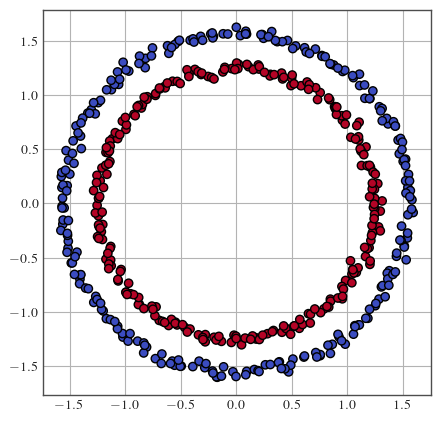

In [10]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [11]:
from dal_toolbox.models.ensemble.base import EnsembleModule
from dal_toolbox.models.utils.callbacks import MetricsHistory

class Net(nn.Module):
    def __init__(self,
                 num_classes: int,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        return out

class Ensemble(EnsembleModule):
    def __init__(self, num_members=10):
        super().__init__([Net(2) for _ in range(num_members)])
    
    def configure_optimizers(self):
        optimizers = [torch.optim.SGD(m.parameters(), lr=1e-1, momentum=0.9) for m in self.members]
        return optimizers

In [12]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    probas = probas.mean(1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | members | ModuleList | 171 K 
---------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.686     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: 

Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 73.79it/s, v_num=93, loss_member0=0.0125, loss_member1=0.0151, loss_member2=0.0034, loss_member3=0.0182, loss_member4=0.00621, loss_member5=0.00464, loss_member6=0.0186, loss_member7=0.00402, loss_member8=0.00632, loss_member9=0.00792]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:00<00:00, 61.17it/s, v_num=93, loss_member0=0.0125, loss_member1=0.0151, loss_member2=0.0034, loss_member3=0.0182, loss_member4=0.00621, loss_member5=0.00464, loss_member6=0.0186, loss_member7=0.00402, loss_member8=0.00632, loss_member9=0.00792]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


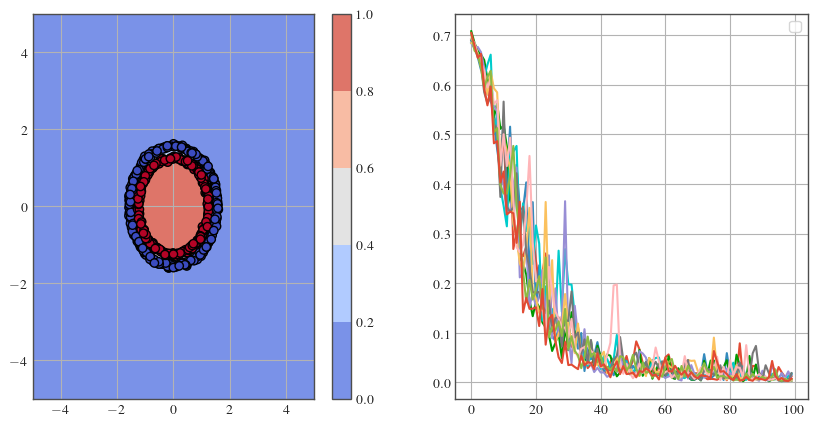

In [13]:
num_members = 10
num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Ensemble(num_members=num_members)
history = MetricsHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_contour(model)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.subplot(122)
plt.legend()
for i in range(num_members):
    plt.plot([d[f'loss_member{i}'] for d in history], label=f'Member {i}')
plt.show()